In [1]:
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

/home/naireen/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dataset = pd.read_csv("../../csvs/BetaFeats/sifOrbsMore=10000.0Nout=100window=10.csv", index_col = 0)
print dataset.columns.values

['runstring' 't_final_short' 'Rel_Eerr_short' 'avg_beta12' 'std_beta12'
 'min_beta12' 'max_beta12' 'avg_beta23' 'std_beta23' 'min_beta23'
 'max_beta23' 'avg_a1' 'std_a1' 'max_a1' 'min_a1' 'norm_std_a1'
 'norm_max_a1' 'norm_std_window10_a1' 'norm_max_window10_a1' 'avg_e1'
 'std_e1' 'max_e1' 'min_e1' 'norm_std_e1' 'norm_max_e1'
 'norm_std_window10_e1' 'norm_max_window10_e1' 'avg_inc1' 'std_inc1'
 'max_inc1' 'min_inc1' 'norm_std_inc1' 'norm_max_inc1'
 'norm_std_window10_inc1' 'norm_max_window10_inc1' 'avg_eH1' 'std_eH1'
 'max_eH1' 'min_eH1' 'avg_iH1' 'std_iH1' 'max_iH1' 'min_iH1' 'avg_ecross1'
 'std_ecross1' 'max_ecross1' 'min_ecross1' 'norm_a1_slope' 'avg_a2'
 'std_a2' 'max_a2' 'min_a2' 'norm_std_a2' 'norm_max_a2'
 'norm_std_window10_a2' 'norm_max_window10_a2' 'avg_e2' 'std_e2' 'max_e2'
 'min_e2' 'norm_std_e2' 'norm_max_e2' 'norm_std_window10_e2'
 'norm_max_window10_e2' 'avg_inc2' 'std_inc2' 'max_inc2' 'min_inc2'
 'norm_std_inc2' 'norm_max_inc2' 'norm_std_window10_inc2'
 'norm_max_window

In [3]:
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 
y = dataset['Stable']
X = dataset[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,norm_a2_slope,norm_a3_slope,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23
0,0.396282,0.481704,0.000329,0.001083,0.000214,0.000456,0.000701,0.001978,0.000446,0.000964,...,2.144832e-10,2.681898e-11,8.488064,0.048209,8.344623,8.551727,15.791595,0.085995,15.576612,16.019985
1,1.034575,0.823935,0.000739,0.002137,0.000202,0.000463,0.000200,0.000350,0.000226,0.000377,...,3.559377e-11,-9.314702e-11,8.414875,0.039142,8.308582,8.495900,15.314101,0.037065,15.254833,15.368196
2,0.440470,0.491261,0.001951,0.003550,0.001735,0.002860,0.002303,0.004034,0.002080,0.003409,...,-3.330088e-11,-4.095504e-11,3.566625,0.132349,3.331239,3.773868,25.113282,0.137779,24.898424,25.351948
3,0.432098,0.550624,0.000026,0.000120,0.000005,0.000009,0.000019,0.000050,0.000016,0.000041,...,7.816527e-13,-7.257099e-12,18.513867,0.003597,18.498104,18.521611,19.142029,0.008997,19.120348,19.156777
4,5.722053,17.442426,0.028284,0.063028,0.004313,0.010716,0.038832,0.160685,0.090892,0.112168,...,3.913858e-08,-2.610208e-08,23.314674,6.756316,3.957209,38.942908,-19.036068,5.544896,-21.930247,4.156005


In [8]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
param = {'num_leaves':100, 'objective':'binary','max_depth':13,
         'learning_rate':.05,'max_bin':200, "bagging_fraction":0.95,
        "seed":0}

param['metric'] = ['auc']

best_xgb={'x_pos_weight': 12.505309968632893, 
          'x_learning_rate': 0.19890696372714528, 
          'x_max_depth': 17, 'x_min_child': 8.0,
          'x_tree_colsample': 0.7528946858805113, 
          'x_subsample': 0.9409498631912948}

xgbc = XGBClassifier(seed = 0, n_estimators=100)
xgbc.param = best_xgb

In [9]:
import time


#XGB
#print score
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
start = time.time()
bst = xgb.train(best_xgb, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print score
end = time.time()
print "XGB", end - start

#LIGHTGBM
train_data = lgb.Dataset(trainX, label=trainY)
num_round=100
start=time.time()
lgbm=lgb.train(param,train_data,num_round)
ypred2=lgbm.predict(testX)
score = metrics.average_precision_score(testY, ypred2)
print score
stop=time.time()
print "LIGHT", stop - start


0.966489098431
XGB 0.584885120392
0.97687100538
LIGHT 1.31996417046


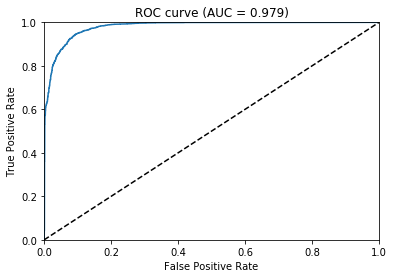

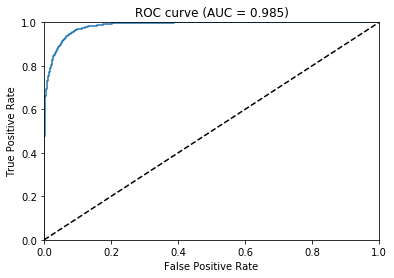

In [10]:
#the ROCAUC score is now 98.0 with the 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))


#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
fpr, tpr, thresholds = roc_curve(testY, ypred2)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, ypred2)))

In [11]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 40):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

    
print "\n\n"
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, ypred2)
for i in range(0,len(recall), 40):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))



Threshold 0.00728341937065, recall = 1.0, precision = 0.422895189003
Threshold 0.00951665639877, recall = 0.999492127984, precision = 0.430446194226
Threshold 0.0122666358948, recall = 0.999492127984, precision = 0.4440433213
Threshold 0.0144209265709, recall = 0.999492127984, precision = 0.565679793044
Threshold 0.0174534618855, recall = 0.999492127984, precision = 0.595101300272
Threshold 0.020818144083, recall = 0.998984255967, precision = 0.614303560275
Threshold 0.0247309803963, recall = 0.998984255967, precision = 0.625238397966
Threshold 0.0286546945572, recall = 0.998476383951, precision = 0.633784655061
Threshold 0.0328362286091, recall = 0.998476383951, precision = 0.643745907007
Threshold 0.0373585522175, recall = 0.998476383951, precision = 0.652722443559
Threshold 0.0435643494129, recall = 0.997968511935, precision = 0.663403106009
Threshold 0.050700455904, recall = 0.997460639919, precision = 0.673756432247
Threshold 0.0588156878948, recall = 0.996952767902, precision = 0

In [13]:
#try running both cv
score = xgb.cv(best_xgb, d_Train, nfold = 5, metrics = "auc", verbose_eval=True)
print np.mean(score)

score = lgb.cv(param, train_data, nfold=  5, metrics="auc", verbose_eval=True)


[0]	train-auc:0.972655+0.000220533	test-auc:0.963794+0.00120836
[1]	train-auc:0.978652+0.000476398	test-auc:0.968425+0.000684824
[2]	train-auc:0.981602+0.000424884	test-auc:0.971111+0.000501975
[3]	train-auc:0.983624+0.000238875	test-auc:0.972266+0.000738087
[4]	train-auc:0.985065+0.000337737	test-auc:0.973069+0.00078347
[5]	train-auc:0.986221+0.000193385	test-auc:0.973596+0.000419402
[6]	train-auc:0.987212+0.000217074	test-auc:0.974086+0.000565332
[7]	train-auc:0.988219+0.000222556	test-auc:0.974278+0.000609536
[8]	train-auc:0.989046+0.000215957	test-auc:0.974686+0.000722027
[9]	train-auc:0.989761+0.000238378	test-auc:0.974993+0.000687065
test-auc-mean     0.972030
test-auc-std      0.000692
train-auc-mean    0.984206
train-auc-std     0.000279
dtype: float64
[1]	cv_agg's auc: 0.964021 + 0.00194028
[2]	cv_agg's auc: 0.968662 + 0.00224066
[3]	cv_agg's auc: 0.970038 + 0.00157369
[4]	cv_agg's auc: 0.970953 + 0.00168995
[5]	cv_agg's auc: 0.971511 + 0.00183203
[6]	cv_agg's auc: 0.972015 + 

In [14]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [15]:
np.mean(score["auc-stdv"])

0.0019134843731719343

In [30]:
space ={
        'num_leaves': hp.quniform("x_leaves", 100,300 ,10),
        'max_depth':hp.quniform ('x_min_child', 1, 15, 1),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'max_bin':hp.quniform ('x_bin', 100, 300, 10), 
        "bagging_fraction":hp.uniform ('x_frac', 0.8,1)
}

def objective(space):
    param = {'num_leaves':space["num_leaves"],
             'max_depth':space["max_depth"],
         'learning_rate':space["learning_rate"],
             'max_bin':space["max_bin"], "bagging_fraction": space["bagging_fraction"],
        "seed":0}
  
        
    clf = lgb.LGBMModel(param, seed = 0, objective="binary")
    score = lgb.cv(param, train_data, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    gradb = lgb.train(param, train_data)
    preds = gradb.predict(testX)
    hold_score = metrics.roc_auc_score(testY, preds)
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    #avg_score =  np.mean(score["test-auc-mean"])
    #error = np.mean(score["test-auc-std"])
    #print hold_score
    print "SCORE: ", max(score["auc-mean"]), "ERROR: ", np.mean(score["auc-stdv"]), "HOLDOUT: ",hold_score

    return {'loss':1-hold_score, 'status': STATUS_OK, "cv_score":max(score["auc-mean"]) , "cv_error":np.mean(score["auc-stdv"])}

In [31]:
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:  0.975121850922 ERROR:  0.00164094868892 HOLDOUT:  0.980981189969
SCORE:  0.973374154782 ERROR:  0.00191085999878 HOLDOUT:  0.982677224462
SCORE:  0.972962449076 ERROR:  0.00214306993457 HOLDOUT:  0.982996927466
SCORE:  0.963683246808 ERROR:  0.00248487690996 HOLDOUT:  0.979250805834
SCORE:  0.975749852647 ERROR:  0.00147798019947 HOLDOUT:  0.981137690287
SCORE:  0.973501904678 ERROR:  0.00218496295829 HOLDOUT:  0.983371589897
SCORE:  0.969971846267 ERROR:  0.00187245220576 HOLDOUT:  0.981036484514
SCORE:  0.975313857417 ERROR:  0.00200929743248 HOLDOUT:  0.979499798845
SCORE:  0.965065421027 ERROR:  0.00239899303098 HOLDOUT:  0.978673899417
SCORE:  0.975762537326 ERROR:  0.00180947234716 HOLDOUT:  0.9781878101
SCORE:  0.972371452665 ERROR:  0.00184004775294 HOLDOUT:  0.9831282939
SCORE:  0.974232447717 ERROR:  0.00195737644385 HOLDOUT:  0.983428057357
SCORE:  0.974949725022 ERROR:  0.00172348860463 HOLDOUT:  0.983888342553
SCORE:  0.975076947759 ERROR:  0.00127623893489 HOLDOUT

In [32]:
best

{'x_bin': 250.0,
 'x_frac': 0.9502137166689373,
 'x_learning_rate': 0.049413384246429486,
 'x_leaves': 110.0,
 'x_min_child': 11.0}

In [54]:
#For further moptimixation

#start = time.time()
#best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 200, trials = trials)
#end = time.time()
#print("Optimization Time: %f seconds", (end  -start))

SCORE: 0.976183274796 ERROR 0.00140680696682
SCORE: 0.976800460107 ERROR 0.00160084610726
SCORE: 0.974336591064 ERROR 0.00134873889508
SCORE: 0.945693650216 ERROR 0.00194135041125
SCORE: 0.976795932665 ERROR 0.00174076391171
SCORE: 0.976650333722 ERROR 0.00168337895497
SCORE: 0.976417604893 ERROR 0.00171450414529
SCORE: 0.977130423325 ERROR 0.00141445299343
SCORE: 0.976243822912 ERROR 0.00144851825303
SCORE: 0.97674649231 ERROR 0.00163599617984
SCORE: 0.97473052497 ERROR 0.00137758640508
SCORE: 0.976318421177 ERROR 0.00120480292239
SCORE: 0.97728671266 ERROR 0.00144122028542
SCORE: 0.976409403213 ERROR 0.0016627524186
SCORE: 0.976888660556 ERROR 0.00171518534289
SCORE: 0.968104273718 ERROR 0.00132499045478
SCORE: 0.973724481668 ERROR 0.00217121175306
SCORE: 0.974942415691 ERROR 0.00197765722732
SCORE: 0.976850123813 ERROR 0.00171363072518
SCORE: 0.975948543023 ERROR 0.00189062395572
SCORE: 0.975644269253 ERROR 0.00174968946953
SCORE: 0.973318994379 ERROR 0.00131652314731
SCORE: 0.97702

0.98413381682


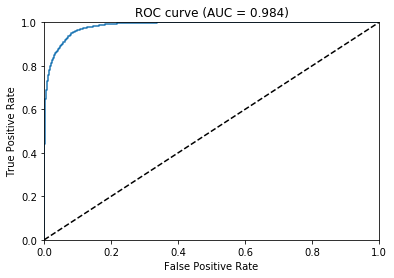

In [38]:
param = {'num_leaves':int(best["x_leaves"]),
         'max_depth':int(best["x_min_child"]),
         'learning_rate':best["x_learning_rate"],
          'max_bin':int(best["x_bin"]), "bagging_fraction": best["x_frac"],
         "seed":0}
  
        
clf = lgb.LGBMModel(param, seed = 0, objective="binary")
#score = lgb.cv(param, train_data, nfold = 5, metrics = "auc", early_stopping_rounds=10)
#print score
gradb = lgb.train(param, train_data)
preds = gradb.predict(testX)
hold_score = metrics.roc_auc_score(testY, preds)
print hold_score

#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
fpr, tpr, thresholds = metrics.roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))